# Create test dataframe

In [3]:
ls

__pycache__/                    test_ETHUSDT_1h.pkl
signal_stat/                    test_ETHUSDT_4h.pkl
test_BTCUSDT_1d.pkl             test_ETHUSDT_5m_indicators.pkl
test_BTCUSDT_1h_indicators.pkl  test_ETHUSDT_5m.pkl
test_BTCUSDT_1h.pkl             test_find_signal.py
test_BTCUSDT_4h.pkl             test_get_data.py
test_BTCUSDT_5m_indicators.pkl  test_indicators.py
test_BTCUSDT_5m.pkl             test.ipynb
test_ETHUSDT_1d.pkl             test_signal_stat.py
test_ETHUSDT_1h_indicators.pkl


In [7]:
import pandas as pd
x = pd.read_pickle('test_BTCUSDT_1h.pkl')
x

,time,open,close,high,low,volume,high_roll,low_roll
0,2022-07-14 00:00:00,19670.02,19923.51,19958.00,19646.24,4535.08807,NaN,NaN
1,2022-07-14 01:00:00,19925.05,19846.97,20030.67,19828.71,6253.71069,NaN,NaN
2,2022-07-14 02:00:00,19845.41,20234.87,20366.61,19835.15,10931.71853,20118.426667,19770.033333
3,2022-07-14 03:00:00,20234.87,20306.05,20430.76,20164.06,8507.47726,20276.013333,19942.640000
4,2022-07-14 04:00:00,20304.55,20277.84,20435.72,20226.64,6851.29598,20411.030000,20075.283333
...,...,...,...,...,...,...,...,...
995,2022-08-24 11:00:00,21319.27,21341.40,21440.07,21300.00,7185.92744,21453.976667,21287.126667
996,2022-08-24 12:00:00,21341.40,21314.67,21397.20,21293.39,5646.55573,21429.756667,21278.893333
997,2022-08-24 13:00:00,21314.67,21282.16,21385.01,21261.00,5679.76892,21407.426667,21284.796667
998,2022-08-24 14:00:00,21282.16,21438.92,21476.23,21271.64,7089.80780,21419.480000,21275.343333


In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory

debug = True
# Set environment variable
environ["ENV"] = "development"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'BTCUSDT': ['1h', '5m'], 'ETHUSDT': ['1h', '5m']}}
# Get configs
configs = ConfigFactory.factory(environ).configs
# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_apis[exchange] = DataFactory.factory(exchange, **configs)
# Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
# Counter
i = 1

    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_api in exchange_apis.items():
    tickers = exchanges[exchange]
    for ticker in tickers:
        timeframes = tickers[ticker]
        for timeframe in timeframes:
            print(f'Cycle number is {i}, exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle('test_ETHUSDT_1d.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, new_data_flag = exchange_api.get_data(df, ticker, timeframe)
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
            if new_data_flag:
                indicators = list()
                if timeframe == work_timeframe:
                    indicator_list = configs['Indicator_list']
                else:
                    indicator_list = ['SUP_RES']
                for indicator in indicator_list:
                    ind_factory = IndicatorFactory.factory(indicator, configs)
                    if ind_factory:
                        indicators.append(ind_factory)
                # Write indicators to dataframe, update dataframe dict
                dfs, df = exchange_api.add_indicator_data(dfs, df, indicators, ticker, timeframe, configs)
                # Get signals
                if timeframe == work_timeframe:
                    fs = FindSignal(configs)
                    points = fs.find_signal(df, dfs[ticker][timeframe]['levels'])
                    # Write statistics
                    ss = SignalStat(**configs)
                    dfs = ss.write_stat(dfs, ticker, timeframe, points)

Cycle number is 1, exchange is Binance, ticker is BTCUSDT, timeframe is 1h
Cycle number is 1, exchange is Binance, ticker is BTCUSDT, timeframe is 5m
[(74, 'sell', Timestamp('2020-02-13 03:00:00')), (242, 'sell', Timestamp('2020-07-30 03:00:00')), (247, 'sell', Timestamp('2020-08-04 03:00:00')), (248, 'sell', Timestamp('2020-08-05 03:00:00')), (401, 'sell', Timestamp('2021-01-05 03:00:00')), (407, 'sell', Timestamp('2021-01-11 03:00:00')), (521, 'sell', Timestamp('2021-05-05 03:00:00')), (528, 'sell', Timestamp('2021-05-12 03:00:00')), (928, 'buy', Timestamp('2022-06-16 03:00:00')), (929, 'buy', Timestamp('2022-06-17 03:00:00'))]
Cycle number is 1, exchange is Binance, ticker is ETHUSDT, timeframe is 1h
Cycle number is 1, exchange is Binance, ticker is ETHUSDT, timeframe is 5m
[(74, 'sell', Timestamp('2020-02-13 03:00:00')), (242, 'sell', Timestamp('2020-07-30 03:00:00')), (247, 'sell', Timestamp('2020-08-04 03:00:00')), (248, 'sell', Timestamp('2020-08-05 03:00:00')), (401, 'sell', Ti

## Plot STOCH values

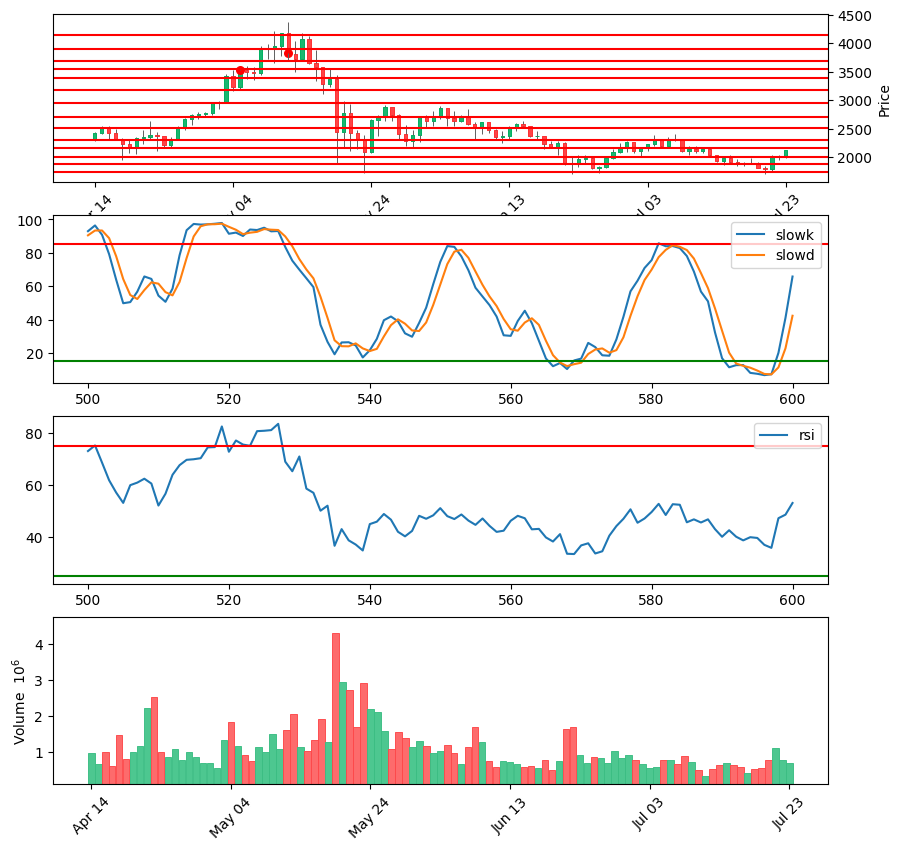

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

low_bound = 500
high_bound = 600

pd.set_option('display.max_rows', 500)

levels = dfs['ETHUSDT']['5m']['levels']

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'])
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'])
# show bounders
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'])
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    scatter_candle_points.append((point[0], df.loc[point[0], 'close']))
#     scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
#     scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))

for point in scatter_candle_points:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')

for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0], point[1], s=30, color='red')

for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0], point[1], s=30, color='red')

# plot levels
for level in levels:
    # show bounders
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')
#         ax1.text(150, level[0], level[0], ha='left', va='center')

In [22]:
np.mean(df['high']-df['low'])

127.05076

In [21]:
levels

[[86.0, 2],
 [232.32, 2],
 [370.23, 2],
 [565.43, 2],
 [936.15, 2],
 [1072.11, 2],
 [1207.0, 2],
 [1356.17, 2],
 [1529.92, 2],
 [1744.85, 2],
 [1877.69, 2],
 [2012.47, 2],
 [2159.0, 2],
 [2300.0, 2],
 [2507.0, 2],
 [2709.26, 2],
 [2954.65, 2],
 [3180.0, 2],
 [3393.6, 2],
 [3555.0, 2],
 [3695.0, 2],
 [3900.73, 2],
 [4137.91, 2],
 [4488.0, 2],
 [4634.83, 2],
 [4868.0, 1]]

NameError: name 'df' is not defined

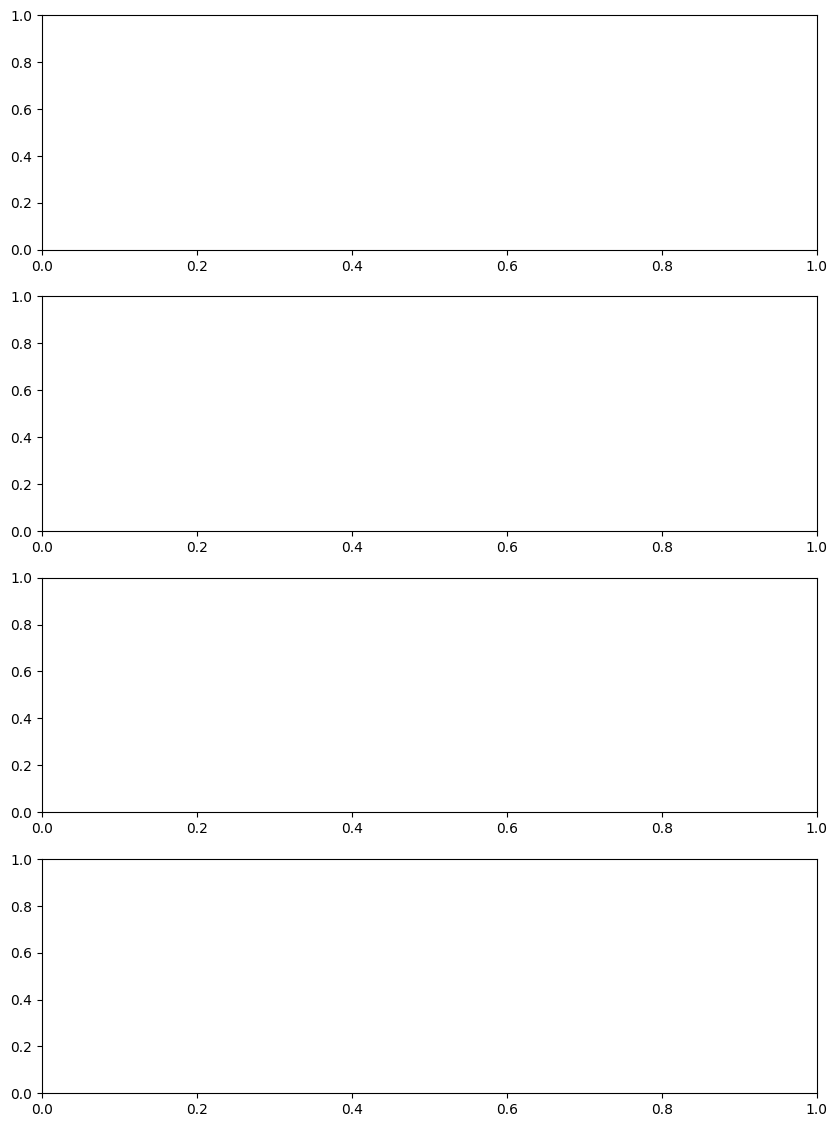

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

pd.set_option('display.max_rows', 500)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 14))

# plot candles
ohlc = df.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# plot STOCH
ax2.plot(df.loc[:, 'stoch_slowk'])
ax2.plot(df.loc[:, 'stoch_slowd'])
# show bounders
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[:, 'rsi'])
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    scatter_candle_points.append((point[0], df.loc[point[0], 'close']))
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))

for point in scatter_candle_points:
#     if 100 < point[0] < 200:
    ax1.scatter(point[0], point[1], s=30, color='red')

for point in scatter_stoch_points:
#     if 100 < point[0] < 200:
    ax2.scatter(point[0], point[1], s=30, color='red')

for point in scatter_rsi_points:
#     if 100 < point[0] < 200:
    ax3.scatter(point[0], point[1], s=30, color='red')

# plot levels
for level in levels:
    # show bounders
    if df.loc[:, 'low'].min() <= level[0] <= df.loc[:, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')